<div style="background: #6883bc; color: white; padding: 10px; font-size: 18pt; line-height: 1.5">
<b><center>Анализ предпочтений авиапассажиров<b>
    
</div>

## Оглавление

[Описание задачи](#description) 

[1 Импорты и настройки](#imports)    
[2 Сбор информации о фестивалях](#festivals)    
[3 Изучение общей информации в датасетах](#start)      
[4 Анализ взаимосвязи модели самолета и количества рейсов](#top)    
[5 Анализ количества полетов по городам](#factors)    

[Общий вывод](#total_conclusion)

<a id='description'></a>
## Описание задачи

Российская авиакомпания «F9», выполняющая внутренние пассажирские авиаперевозки, нуждается в анализе перелетов для выявления предпочтения пассажиров, покупающих билеты на те или иные направления.

Цель - изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

<a id='imports'></a>
### 1 Импорты и настройки

In [7]:
!pip install folium -q

In [8]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [10]:
sns.set(style="ticks")

In [11]:
def first_look(df):
    display(df.info())
    display(df.head(5))
    display(df.describe())

<a id='festivals'></a>
### 2 Сбор информации о фестивалях

Соберем информацию об 11 крупнейших фестивалях 2018 года

In [12]:
URL = 'https://***.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('table',attrs={'id': 'best_festivals'})
head_table = []
for row in table.find_all('th'):
    head_table.append(row.text)
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

festivals = pd.DataFrame(content, columns = head_table)

In [13]:
print(festivals)

                                  Название фестиваля Место проведения  \
0               Музыкальный фестиваль «Усадьба Jazz»     Екатеринбург   
1   Фестиваль музыки и технологий Alfa Future People  Нижний Новгород   
2                        Фестиваль еды «О, да! Еда!»  Санкт-Петербург   
3                                          Доброфест        Ярославль   
4                                          Park Live           Москва   
5                                       Пикник Афиши           Москва   
6                                            VK FEST  Санкт-Петербург   
7                            Фестиваль «О, да! Еда!»          Иркутск   
8                            Фестиваль «О, да! Еда!»      Владивосток   
9                                            Видфест           Москва   
10                                  «Нашествие 2018»            Тверь   

   Дата проведения  
0       01.07.2018  
1       10.08.2018  
2       21.07.2018  
3       29.07.2018  
4       28.07.2018

<a id='start'></a>
### 3 Изучение общей информации в датасетах

In [14]:
flights_by_model = pd.read_csv('/datasets/query_1.csv')

In [15]:
flights_to_city  = pd.read_csv('/datasets/query_3.csv')

In [16]:
first_look(flights_by_model)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


None

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


,flights_amount
count,8.00
mean,2035.62
std,1965.20
min,300.00
25%,605.25
50%,795.00
75%,4250.25
max,4557.00


Датасет `flights_by_model` состоит из 2 столбцов - модель самолета и количество рейсов, совершенных в сентябре 2018г. Таблица содержит 8 записей, все значения заполнены, типы данных соответствуют содержащимся в них данных.
Среднее и медианное значение количества полетов отличаются друг от друга более чем в 2 раза, данные распределены неравномерно, имеют положительную асимметрию, значит, в данных будет наблюдаться длинный хвост и перекос вправо.

In [17]:
first_look(flights_to_city)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


None

,city,average_flights
0,Абакан,3.87
1,Анадырь,1.00
2,Анапа,2.16
3,Архангельск,5.35
4,Астрахань,2.45


,average_flights
count,101.00
mean,5.49
std,13.12
min,1.00
25%,2.00
50%,3.00
75%,5.87
max,129.77


Датасет `flights_to_city` состоит из 2 столбцов - город и среднедневное количество рейсов, совершенных в августе 2018г. Таблица содержит 101 запись, все значения заполнены, типы данных соответствуют содержащимся в них данных.
Среднее по столбцу среднедневного количества рейсов больше медианного значения, здесь также наблюдаем положительную асимметрию, длинный хвост и перекос вправо, вызванные наличием необычайно высоких значений.

Таким образом, данные не нуждаются в дополнительной предобработке - пропущенные значения отсутствуют, а типы данных соответствуют содержащимся в них данным. Проанализируем полученную информацию.

<a id='top'></a>
### 4 Анализ взаимосвязи модели самолета и количества рейсов

In [18]:
flights_by_model.sort_values('flights_amount', ascending = False)

,model,flights_amount
6,Cessna 208 Caravan,4557
5,Bombardier CRJ-200,4446
7,Sukhoi SuperJet-100,4185
1,Airbus A321-200,960
2,Boeing 737-300,630
0,Airbus A319-100,607
3,Boeing 767-300,600
4,Boeing 777-300,300


Text(0.5, 0, 'Количество рейсов, шт.')

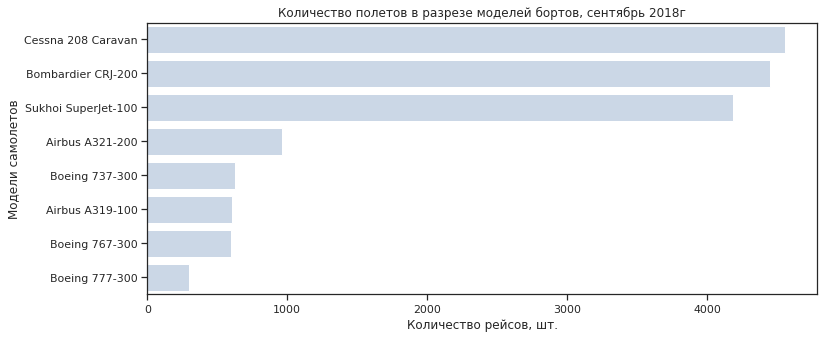

In [19]:
plt.figure(figsize=(12,5))
sns.barplot(data=flights_by_model.sort_values('flights_amount', ascending = False),\
            x='flights_amount', y='model', color='#c6d7eb')
plt.title('Количество полетов в разрезе моделей бортов, сентябрь 2018г')
plt.ylabel('Модели самолетов')
plt.xlabel('Количество рейсов, шт.')

На графике видно, что в зависимости от количества полетов модели самолетов можно условно разделить на 2 группы - в первой группе разновидности моделей Airbas и Boeing (с количеством полетом до 1000), во второй - остальные борты (количество полетов более 4000).
Вероятнее всего это связано с вместимостью бортов, ведь небольшому самолету нужно большее количество рейсов, чтобы перевести то же количество пассажиров, нежели большому. Изучим этот вопрос более подробно, добавив из внешних источников информацию о количестве мест в каждой из моделей.

In [20]:
seats = {'Sukhoi SuperJet-100' : 103, 'Cessna 208 Caravan' : 14, 'Bombardier CRJ-200' : 50,\
         'Boeing 777-300' : 550, 'Boeing 767-300' : 375, 'Boeing 737-300' : 149,\
          'Airbus A321-200' : 188, 'Airbus A319-100' : 156}

for flight in flights_by_model['model']:
    flights_by_model.loc[flights_by_model['model'] == flight, 'seats'] = seats.get(flight)

flights_by_model['seats'] = flights_by_model['seats'].astype(int)

In [21]:
flights_by_model

,model,flights_amount,seats
0,Airbus A319-100,607,156
1,Airbus A321-200,960,188
2,Boeing 737-300,630,149
3,Boeing 767-300,600,375
4,Boeing 777-300,300,550
5,Bombardier CRJ-200,4446,50
6,Cessna 208 Caravan,4557,14
7,Sukhoi SuperJet-100,4185,103


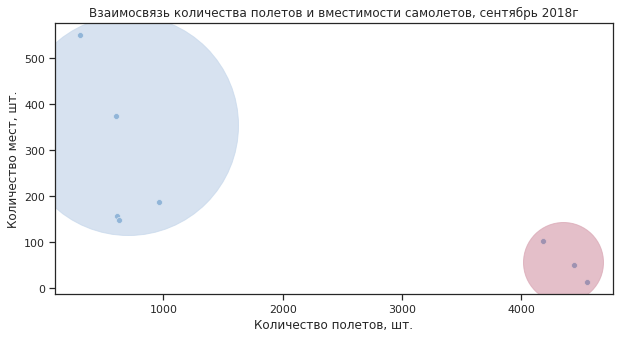

In [22]:
plt.figure(figsize=(10,5))
a = sns.scatterplot(data=flights_by_model, x='flights_amount', y='seats', color='#1868ae')
a.set_title('Взаимосвязь количества полетов и вместимости самолетов, сентябрь 2018г')
a.set_ylabel('Количество мест, шт.')
a.set_xlabel('Количество полетов, шт.')
a.plot([4350],[58],'o', ms=80, mec='#d9a5b3', mfc='#d9a5b3', alpha = 0.7)
a.plot([700],[355],'o', ms=220, mec='#c6d7eb', mfc='#c6d7eb', alpha = 0.7)


Действительно, выдвинутое предположение нашло подтверждение на графике - самолеты с меньшей вместимостью совершают большее количество рейсов. Посчитаем расчетное максимальное количество пассажиров, которое могло быть перевезено за то количество рейсов, что самолеты сделали в сентябре 2018г.

In [23]:
flights_by_model['count_pass'] = flights_by_model['seats'] * flights_by_model['flights_amount']

Text(0.5, 0, 'Расчетное количество пассажиров, шт.')

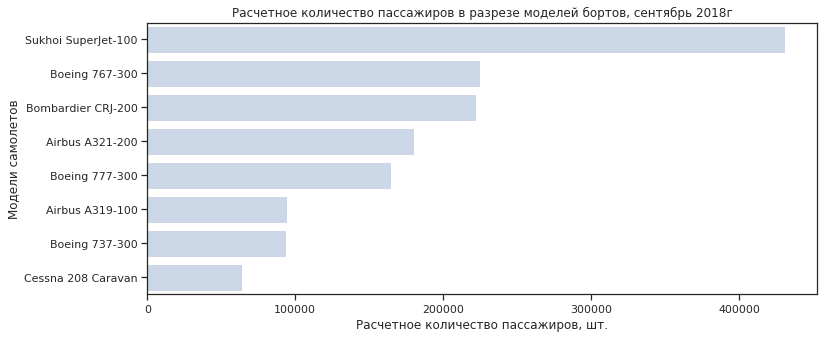

In [24]:
plt.figure(figsize=(12,5))
sns.barplot(data=flights_by_model.sort_values('count_pass', ascending = False),\
            x='count_pass', y='model', color='#c6d7eb')
plt.title('Расчетное количество пассажиров в разрезе моделей бортов, сентябрь 2018г')
plt.ylabel('Модели самолетов')
plt.xlabel('Расчетное количество пассажиров, шт.')

В случае перевода рейсов на расчетное количество пассажиров, результаты будут несколько иными - лидером станет Sukhoi SuperJet-100, ранее занимавший 3 место по количеству полетов, а вот наименьшее количество пассажиров могло быть перевезено бортом Cessna 208 Caravan, несмотря на то, что количество рейсов у данной модели было максимальное за анализируемый период (4557).

Второе место поделили Boeing 767-300 и Bombardier CRJ-200, хотя по количеству рейсов эти модели находились в разных группах (600 и 4446 полетов соответственно), но по количеству пассажиров, которые могли быть перевезены за количество совершенных в сентябре рейсов, можно сказать, что они пользуются примерно равной популярностью.

<a id='factors'></a>
### 5  Анализ количества полетов по городам

Визуализируем, какое количество полетов совершалось в разные города России в августе 2018г. Поскольку сделать читаемый график будет затруднительно в силу большого количества записей (101 шт), наложим информацию о среднедневном количестве прилетов по городам на карту России.

In [25]:
# загрузим файл со справочной информацией, из него возьмем географические координаты городов
map_distr = pd.read_csv('https://raw.githubusercontent.com/hflabs/city/master/city.csv')

In [26]:
map_distr.columns

Index(['address', 'postal_code', 'country', 'federal_district', 'region_type',
       'region', 'area_type', 'area', 'city_type', 'city', 'settlement_type',
       'settlement', 'kladr_id', 'fias_id', 'fias_level', 'capital_marker',
       'okato', 'oktmo', 'tax_office', 'timezone', 'geo_lat', 'geo_lon',
       'population', 'foundation_year'],
      dtype='object')

In [27]:
# уберем неиспользуемые столбцы, оставим только наименование города и координаты
map_distr.drop(columns=['address', 'postal_code', 'country', 'federal_district', 'region_type',
       'region', 'area_type', 'area', 'city_type', 'settlement_type',
       'settlement', 'kladr_id', 'fias_id', 'fias_level', 'capital_marker',
       'okato', 'oktmo', 'tax_office', 'timezone',
       'population', 'foundation_year'], inplace=True)

In [28]:
flights_to_city = flights_to_city.merge(map_distr, left_on='city', right_on='city', how='left')

In [29]:
# Добавим вручную локации для самых крупных городов
flights_to_city.loc[flights_to_city['city']=='Москва', 'geo_lat'] = 55.7540471
flights_to_city.loc[flights_to_city['city']=='Москва', 'geo_lon'] = 37.620405

flights_to_city.loc[flights_to_city['city']=='Санкт-Петербург', 'geo_lat'] = 59.9391313
flights_to_city.loc[flights_to_city['city']=='Санкт-Петербург', 'geo_lon'] = 30.3159004

In [30]:
flights_to_city.sort_values('average_flights').tail()

,city,average_flights,geo_lat,geo_lon
21,Екатеринбург,11.32,56.84,60.61
35,Красноярск,11.58,56.01,92.85
57,Новосибирск,17.32,55.03,82.92
73,Санкт-Петербург,31.16,59.94,30.32
46,Москва,129.77,55.75,37.62


In [31]:
lat = flights_to_city['geo_lat']
lon = flights_to_city['geo_lon']
flights = round(flights_to_city['average_flights'], 2)

def color_change(flights):
    if(flights < 5):
        return('green')
    elif(5 <= flights < 9):
        return('orange')
    else:
        return('red')

map = folium.Map(location=[55.,45.], zoom_start = 5)

marker_cluster = MarkerCluster().add_to(map)

for lat, lon, flights in zip(lat, lon, flights):
    folium.CircleMarker(location=[lat, lon], radius = 9, popup=str(flights),\
                        fill_color=color_change(flights), color="gray", fill_opacity = 0.9).add_to(marker_cluster)

map.save("map1.html")

In [32]:
map

Выделим топ-10 городов с максимальным среднедневным количеством прилетов в августе 2018г.

In [33]:
top_10 = flights_to_city.sort_values('average_flights', ascending=False)[['city', 'average_flights']].head(10)
top_10

,city,average_flights
46,Москва,129.77
73,Санкт-Петербург,31.16
57,Новосибирск,17.32
35,Красноярск,11.58
21,Екатеринбург,11.32
70,Ростов-на-Дону,10.19
66,Пермь,10.13
11,Брянск,10.00
77,Сочи,9.61
87,Ульяновск,9.58


Text(0.5, 0, 'Среднее количество рейсов в день, шт.')

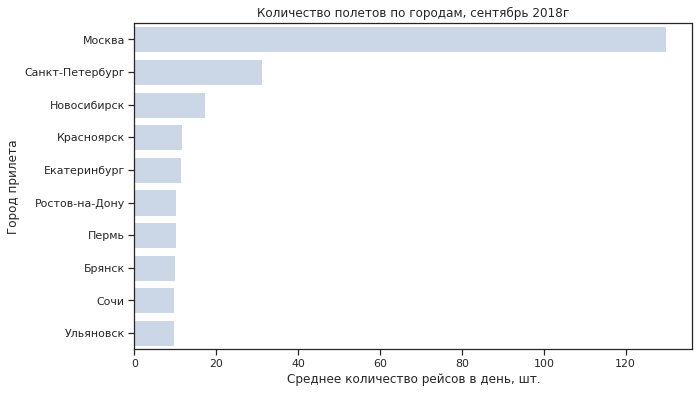

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(data = top_10, x='average_flights', y='city', color='#c6d7eb')
plt.title('Количество полетов по городам, сентябрь 2018г')
plt.ylabel('Город прилета')
plt.xlabel('Среднее количество рейсов в день, шт.')


Предсказуемо лидером по количеству прилетов является Москва, имеющая почти 130 прилетов ежедневно, с большим отрывом от столицы идет следующий за ней Санкт-Петербург, где число прилетов в 4 раза меньше и исчисляется уже двузначной цифрой - около 31 прилета в день. Третьим по полуярности городом стал Новосибирск, где в среднем в день встречают 17 рейсов.
Начиная с 4 места количество прилетов составляет в среднем 10-12 в день.

<a id='total_conclusion'></a>
## Общий вывод

Модели самолетов в зависимости от количества совершаемых рейсов в сентябре 2018г. условно можно разделить на 2 группы:
* модели Airbas и Boeing с количеством полетом до 1000
* самолеты небольшой вместимости с количеством полетов более 4000 (Sukhoi SuperJet, Cessna, Bombardier)

Самолеты с меньшей вместимостью совершают большее количество рейсов, но это не позволяет судить о популярности направлений, обслуживаемых такими бортами. Как было показано на примере расчетного количества пассажиров для каждой из моделей, результаты и выводы будут иными, если ориентироваться на количество перевезенных пассажиров, что будет более точно олицетворять спрос. Таким образом, для более корректного анализа необходимо рассматривать не количество рейсов, а пассажиропоток. 

По количеству прилетов в августе 2018г. первые 7 мест занимают города-миллионники во главе с Москвой и Санкт-Петербургом, и это вполне естественно, что именно в эти города прилетают самое большое количество рейсов, ведь они собирают прилетающих из множества городов России. На последних 3 строчках расположились уже не такие большие города, с населением около полумиллиона, но именно в эти города, вероятнее всего, и летают самолеты небольшой вместимости, такие как Bombardier и Sukhoi SuperJet, перевозя за один раз не так много пассажиров, но зато обеспечивая регулярный трансфер с крупными транспортными узлами.

В августе 2018г. проходили фестивали в городах (не считая Москвы): Нижний Новгород, Иркутск и Тверь. Ни один из этих городов не попал в топ по прилетам, однако, это не позволяет сделать вывод об отсутствии спроса пассажиров на рейсы в города, где проходили эти фестивали. Для корректного ответа на этот вопрос необходимо провести анализ спроса по городам фестивалей в динамике и посмотреть, есть ли различие в спросе в периоды, когда фестивали проводятся, и периоды без мероприятий.